# 군집분석

한 기업이 해킹을 당해서 우리에게 도움을 요청했습니다! 다행스럽게도 그 기업의 포렌식 기술자들은 session time, location, wpm typing speed 등과 같은 해킹에 대한 귀중한 정보를 수집했습니다. 담당 포렌식 기술자와의 회의에서 듣기로는 해커들이 서버에 접속하는데에 사용한 각 세션의 메타 데이터들을 수집한 것이라고 합니다.

다음은 수집된 데이터입니다

- Session_Connection_Time : 세션이 지속된 시간(분)입니다. (해커가 있었던 시간)
- Bytes Transferred : 세션 중에 전송된 데이터 용량(MB)입니다.
- Kali_Trace_Used : 해커의 Kali Linux 사용 여부입니다. (해킹운영체제사용여부)
- Servers_Corrupted : 공격으로 손상된 서버 수 입니다.
- Pages_Corrupted : 무단으로 접근한 페이지 수 입니다.
- Location : 공격이 시작된 위치입니다.(해커들이 VPN을 사용했기 때문에 아마 쓸모가 없을 것 같습니다. vpn 돌려서 왔다리갔다리...)
- WPM_Typing_Speed : 세션 로그를 기준으로 예상한 타이핑 속도입니다. (명령 코드)

이 회사에서는 3명의 해커를 의심 중입니다. 2명의 해커는 어느정도 확신하고 있지만 세 번째 해커가 해킹에 연루되었는지 아직 확실하지 않습니다. 우리에게 의뢰한 부분은 이 부분입니다. 즉, 이번 해킹 사건에서 2명이 공격을 한 것인지 3명이 공격을 한 것인지 분석해달라고 합니다. 확실하지는 않지만 클러스터링으로 알아 볼 수 있을 것 같습니다.

마지막으로 한가지 알려드릴 중요한 사실은, 각 해커들의 공격횟수는 거의 동일합니다. 예를 들어, 총 공격 횟수가 100번 이었다면, 50건씩 2명이 공격을 했거나 3명이 약 33건씩 공격을 했다는 말입니다. 데이터는 hack_data.csv 파일로 전달해 드리겠습니다.

In [ ]:
# 공격횟수를 일치 시키는 변태적인 습관이 있다 

In [83]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# 차이 검정할것임
from scipy import stats

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer 
from sklearn.preprocessing import MinMaxScaler


# 데이터 까보기

In [2]:
df = pd.read_csv("./data/hack_data.csv")

In [4]:
df.head()

,Session_Connection_Time,Bytes Transferred,Kali_Trace_Used,Servers_Corrupted,Pages_Corrupted,Location,WPM_Typing_Speed
0,8.0,391.09,1,2.96,7.0,Slovenia,72.37
1,20.0,720.99,0,3.04,9.0,British Virgin Islands,69.08
2,31.0,356.32,1,3.71,8.0,Tokelau,70.58
3,2.0,228.08,1,2.48,8.0,Bolivia,70.80
4,20.0,408.50,0,3.57,8.0,Iraq,71.28


In [3]:
df.shape

(334, 7)

In [5]:
df.dtypes

Session_Connection_Time    float64
Bytes Transferred          float64
Kali_Trace_Used              int64
Servers_Corrupted          float64
Pages_Corrupted            float64
Location                    object
WPM_Typing_Speed           float64
dtype: object

In [6]:
df.isna().sum()

Session_Connection_Time    0
Bytes Transferred          0
Kali_Trace_Used            0
Servers_Corrupted          0
Pages_Corrupted            0
Location                   0
WPM_Typing_Speed           0
dtype: int64

In [8]:
# 오잉 결측치도 없네요잉 깔꼼~

In [37]:
df.describe()

,Session_Connection_Time,Bytes Transferred,Kali_Trace_Used,Servers_Corrupted,Pages_Corrupted,WPM_Typing_Speed
count,334.000000,334.000000,334.000000,334.000000,334.000000,334.000000
mean,30.008982,607.245269,0.511976,5.258503,10.838323,57.342395
std,14.088201,286.335932,0.500607,2.301907,3.063526,13.411063
min,1.000000,10.000000,0.000000,1.000000,6.000000,40.000000
25%,18.000000,372.200000,0.000000,3.122500,8.000000,44.127500
50%,31.000000,601.650000,1.000000,5.285000,10.500000,57.840000
75%,42.000000,843.702500,1.000000,7.400000,14.000000,70.577500
max,60.000000,1330.500000,1.000000,10.000000,15.000000,75.000000


In [74]:
# 진짜 Location 필요없나?

In [75]:
df["Location"].value_counts()

Location
United States Virgin Islands                    6
Mauritania                                      5
Czech Republic                                  5
Guinea-Bissau                                   5
Palestinian Territory                           4
                                               ..
Antarctica (the territory South of 60 deg S)    1
Myanmar                                         1
Belgium                                         1
Germany                                         1
Canada                                          1
Name: count, Length: 181, dtype: int64

- United States Virgin Islands 라는 곳에서 가장 많이 접속

# 독립변수의 상관관계 알아보기

In [64]:
clean_df = df.drop(["Location"], axis = 1)
clean_df.corr()

,Session_Connection_Time,Bytes Transferred,Kali_Trace_Used,Servers_Corrupted,Pages_Corrupted,WPM_Typing_Speed
Session_Connection_Time,1.000000,0.713861,0.034687,0.808394,0.844167,-0.866077
Bytes Transferred,0.713861,1.000000,0.072436,0.739822,0.784081,-0.793344
Kali_Trace_Used,0.034687,0.072436,1.000000,0.033242,0.016931,-0.026560
Servers_Corrupted,0.808394,0.739822,0.033242,1.000000,0.897210,-0.915629
Pages_Corrupted,0.844167,0.784081,0.016931,0.897210,1.000000,-0.968662
WPM_Typing_Speed,-0.866077,-0.793344,-0.026560,-0.915629,-0.968662,1.000000


In [ ]:
# Session_Connection_Time 와 Servers_Corrupted 상관관계 있음
# Session_Connection_Time 와 Pages_Corrupted 상관관계 있음
# Session_Connection_Time 와 WPM_Typing_Speed 상관관계 있음
# Session_Connection_Time 와 Bytes Transferred 상관관계 있음
# 뭔가 여기서 Session_Connection_Time 과 모든 상관관계가 유의미 한지 체크해야함

<Axes: xlabel='Session_Connection_Time', ylabel='Servers_Corrupted'>

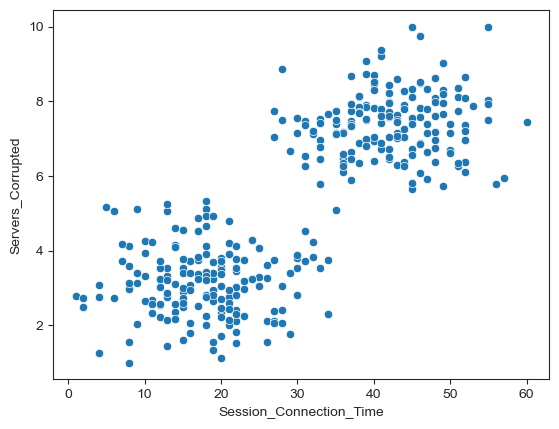

In [66]:
sns.scatterplot(data=clean_df, x="Session_Connection_Time", y="Servers_Corrupted")

## 군집 양상이 보임
- session_conection_time 이 0~35 쯤과
- 35~ 60 정도 로 나눠지는데
- 2명인가...

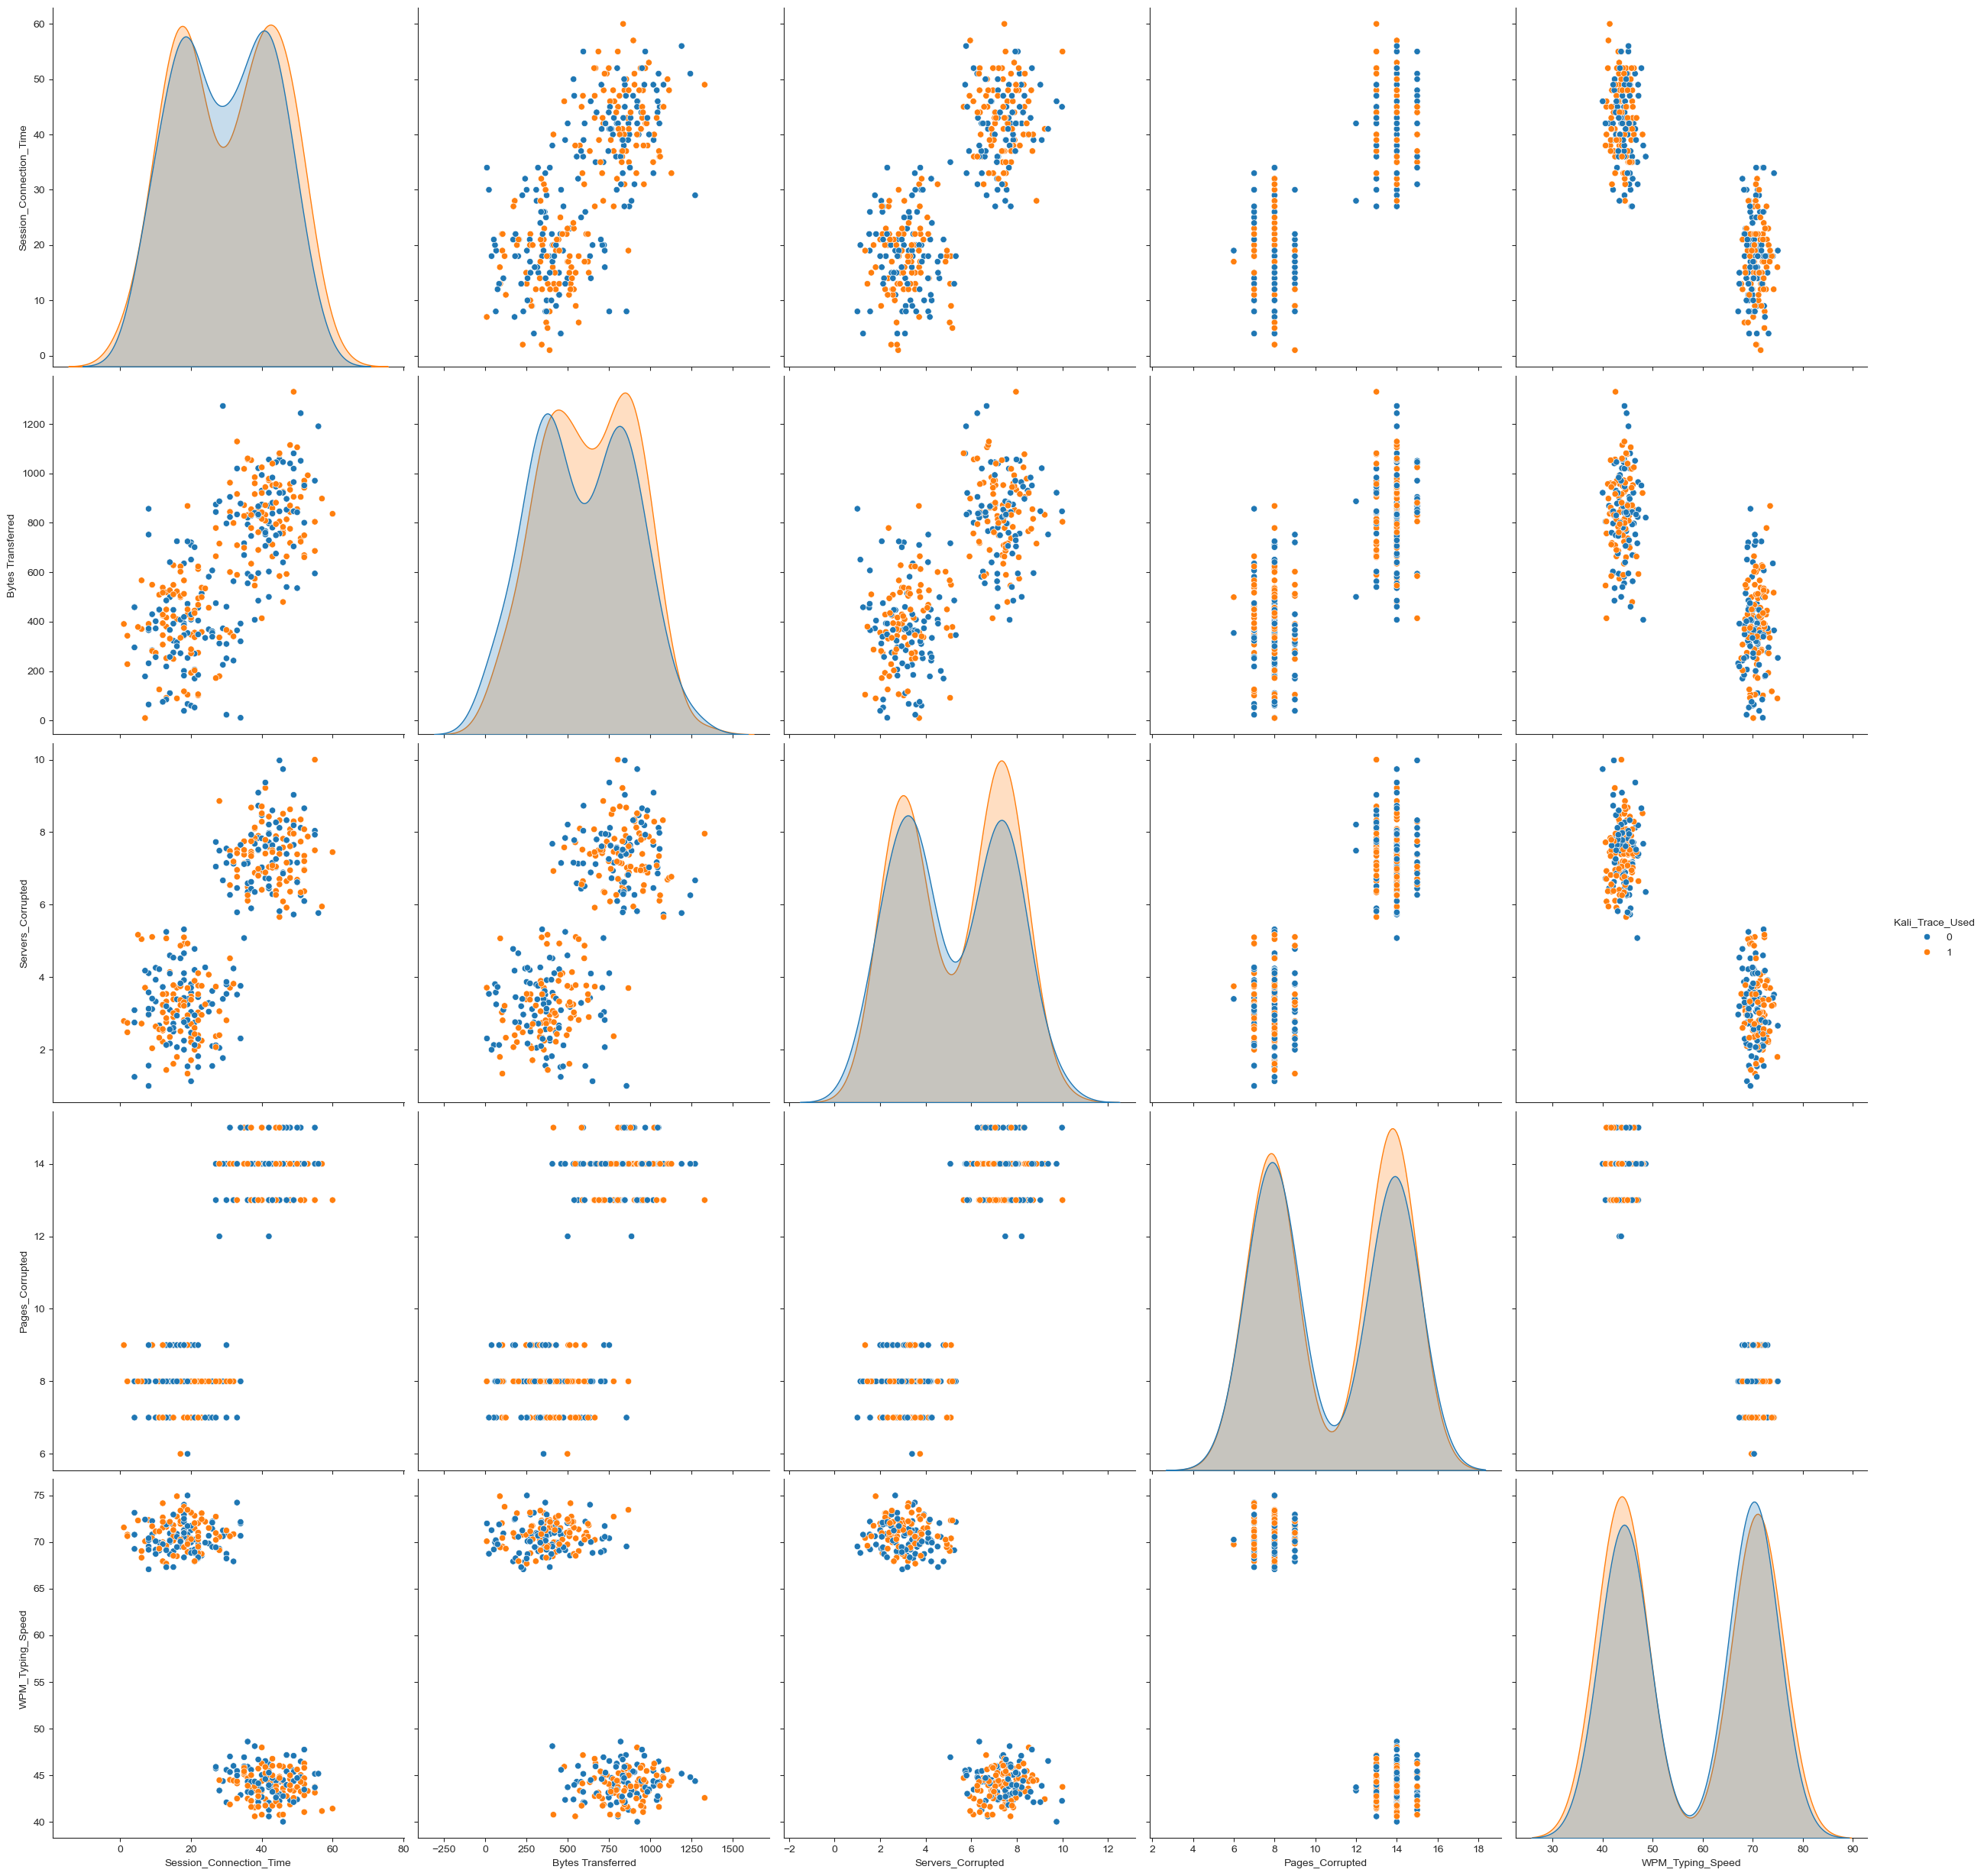

In [65]:
sns.set_style("ticks")
sns.pairplot(clean_df, hue = "Kali_Trace_Used", height = 5)
plot_kws = {"s" : 100}
plt.show()

# 2명이라고 의심은 되는데 한번 확인은 해봐야해서

# EDA 해보기

# 가설 1 : Kali_Trace_Used 사용과 Pages_Corrupted 는 차이가 있을것이다

In [ ]:
# 사용여부에따라 망가진 서버 수를 알아보니 큰차이는 없는거 같은데...(상관계수 ttest_ind 를 찍어보면 좀 알수있나용)

In [29]:
# 서버가 망가짐!
df.groupby("Kali_Trace_Used")["Servers_Corrupted"].sum()

Kali_Trace_Used
0    844.38
1    911.96
Name: Servers_Corrupted, dtype: float64

In [30]:
# 페이지가 망가짐!

In [22]:
df.groupby("Kali_Trace_Used")["Pages_Corrupted"].sum()

Kali_Trace_Used
0    1758.0
1    1862.0
Name: Pages_Corrupted, dtype: float64

In [ ]:
# Kali_Trace_Used 사용여부가 서버가 당한거랑 차이가 있는지 알아봐야것어

In [31]:
not_used1 = df[df["Kali_Trace_Used"] == 0 ]["Servers_Corrupted"]
used1 = df[df["Kali_Trace_Used"] == 1 ]["Servers_Corrupted"]

In [32]:
# 해킹프로그램 사용 여부에 따름
not_used2 = df[df["Kali_Trace_Used"] == 0 ]["Pages_Corrupted"]
used2 = df[df["Kali_Trace_Used"] == 1 ]["Pages_Corrupted"]

In [33]:
t_statistic, p_value = stats.ttest_ind(not_used1, used1)
# 검정 결과 출력
print("t-statistic:", t_statistic)
print("p-value:", p_value)

t-statistic: -0.6060308440369786
p-value: 0.5449083806489052


In [34]:
t_statistic, p_value = stats.ttest_ind(not_used2, used2)
# 검정 결과 출력
print("t-statistic:", t_statistic)
print("p-value:", p_value)

t-statistic: -0.30854581740815495
p-value: 0.7578605535631546


### 딱히 해킹운영체제의 사용여부와 망가진 서버, 페이지 수는 상관이 없음

In [19]:
hack_df["Pages_Corrupted"].unique()

array([ 7.,  8.,  9.,  6., 14., 15., 13.])

# 사람을 구별하는 기준을 뭐로 잡아야함? 공격횟수?

In [76]:
# 1. Servers_Corrupted 를 기준으로 분석을 진행해보자

In [78]:
clean_df

,Session_Connection_Time,Bytes Transferred,Kali_Trace_Used,Servers_Corrupted,Pages_Corrupted,WPM_Typing_Speed
0,8.0,391.09,1,2.96,7.0,72.37
1,20.0,720.99,0,3.04,9.0,69.08
2,31.0,356.32,1,3.71,8.0,70.58
3,2.0,228.08,1,2.48,8.0,70.80
4,20.0,408.50,0,3.57,8.0,71.28
...,...,...,...,...,...,...
329,39.0,761.91,1,6.99,14.0,43.23
330,43.0,983.48,0,8.60,13.0,43.21
331,39.0,690.22,1,6.80,13.0,42.75
332,36.0,1060.69,1,6.26,14.0,43.86


In [95]:
# 두명으로 쪼개보자
km  = KMeans(n_clusters = 2, random_state = 33)
km.fit(clean_df)

# 최저 SSE 값
print("" ,km.inertia_)

# 반복횟수
print(km.n_iter_)

 6914859.905711957
4


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Window

<Axes: >

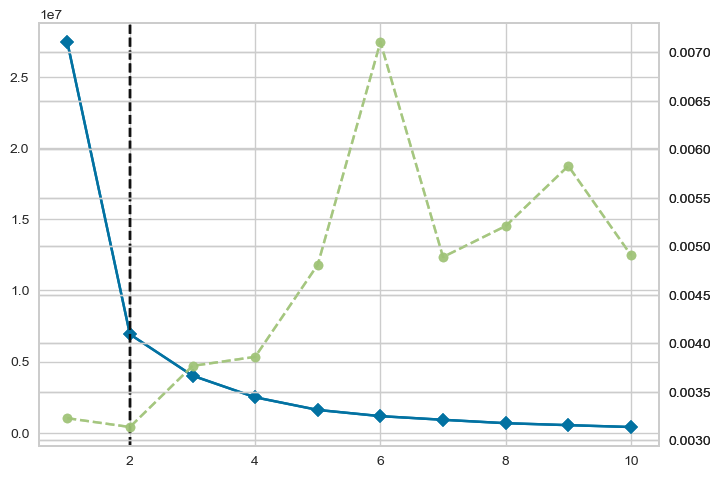

In [85]:
# 엘보우 차트 시각화
elbow_chart = KElbowVisualizer(km, k = (1,11)) # range 1 부터 11 까지
elbow_chart.fit(clean_df)
elbow_chart.draw()

# 속지 말어라

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Window

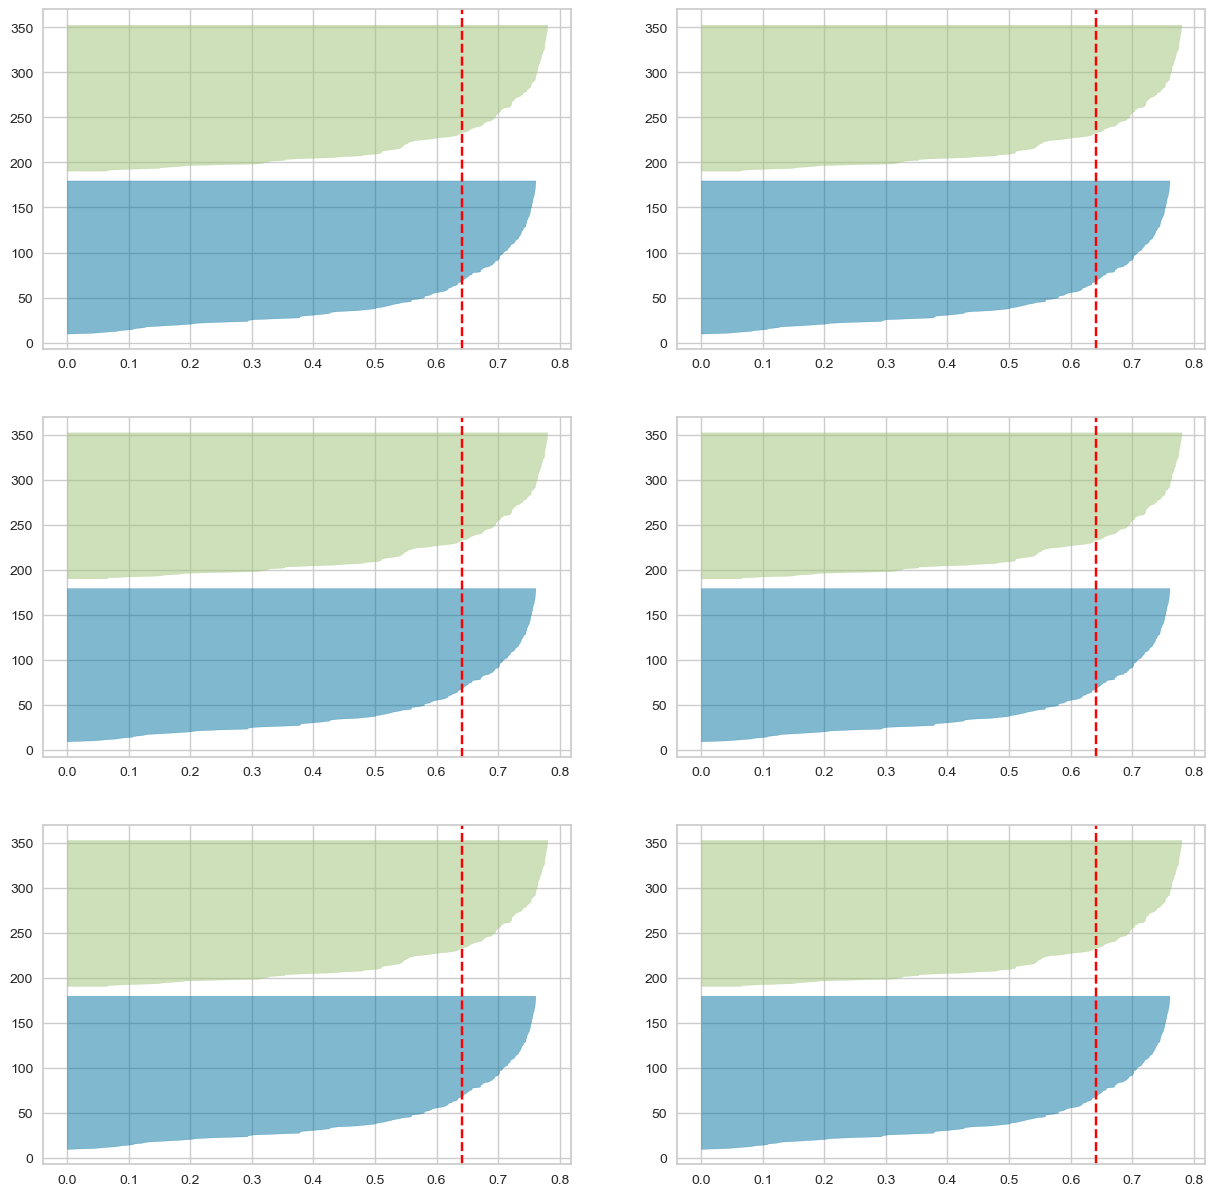

In [90]:
# 시각화
fig, ax = plt.subplots(3, 2, figsize = (15,15))

for i in range(2, 8):
    # k-means 모델
    kmeans_model = KMeans(n_clusters=2, random_state=33)

    q, mod = divmod(i, 2)

    # 실루엣 계수 시각화
    visualizer = SilhouetteVisualizer(kmeans_model, colors = "yellowbrick", ax = ax[q-1][mod])

    visualizer.fit(clean_df)

# 균등하니 이쁘네여?

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Window

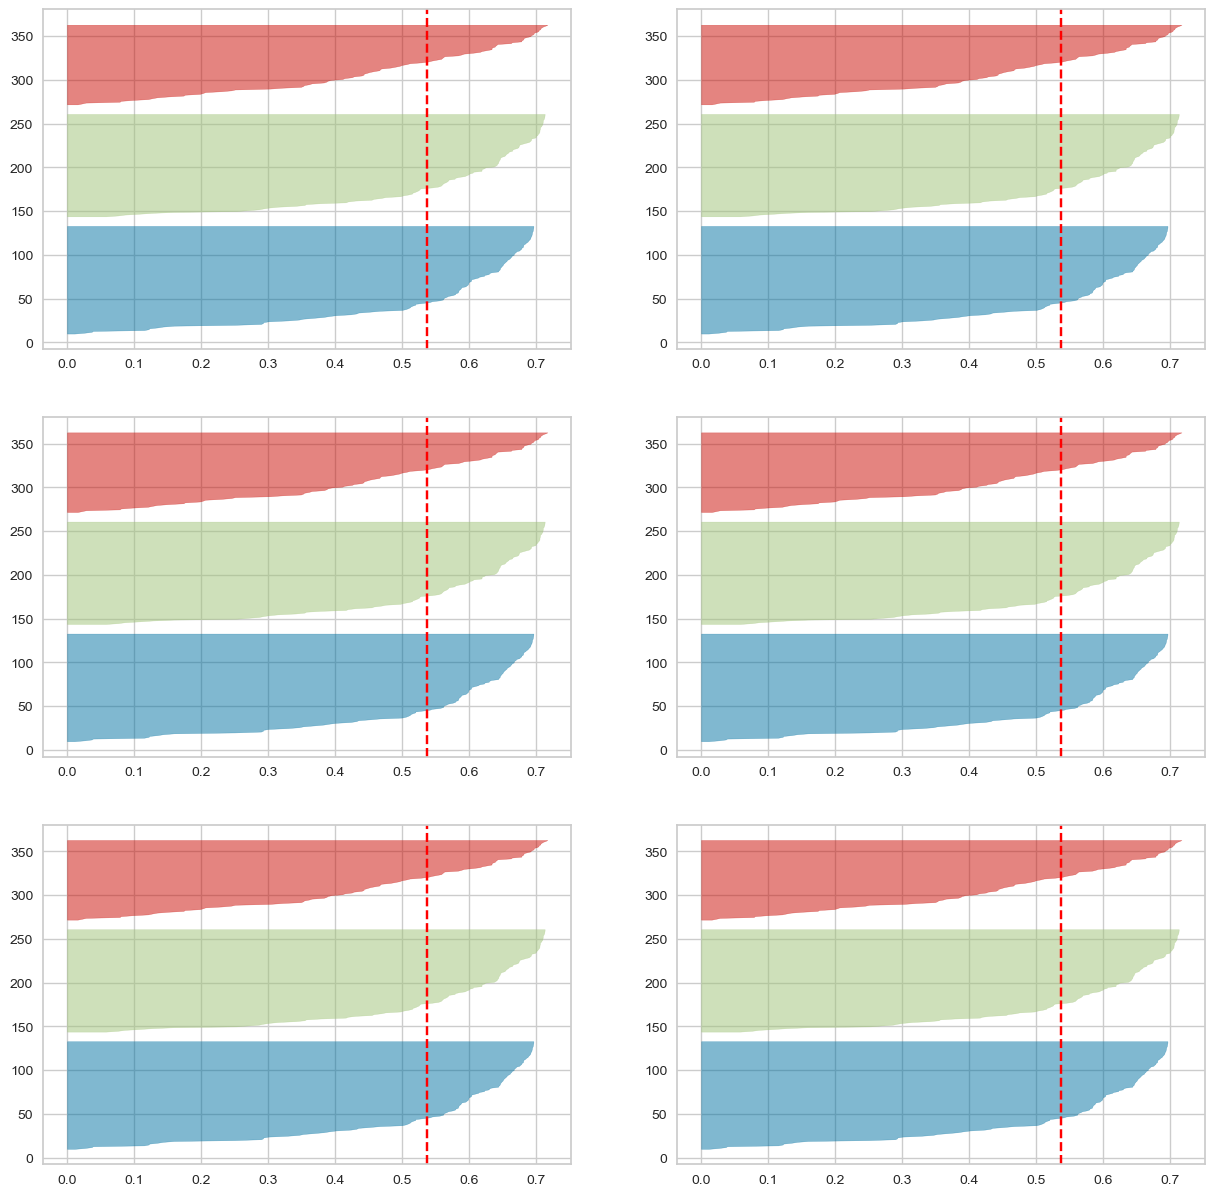

In [91]:
# 시각화
fig, ax = plt.subplots(3, 2, figsize = (15,15))

for i in range(2, 8):
    # k-means 모델
    kmeans_model = KMeans(n_clusters=3, random_state=33)

    q, mod = divmod(i, 2)

    # 실루엣 계수 시각화
    visualizer = SilhouetteVisualizer(kmeans_model, colors = "yellowbrick", ax = ax[q-1][mod])

    visualizer.fit(clean_df)

# 이거 보세요 3명이 한게 아닌듯